# Import Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import matplotlib.pyplot as plt


# Data Preprocessing

In [ ]:
# Load the data
data = pd.read_csv('../datasets/meta.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)



         Date   Open   High    Low    Close     Volume
0  2012-05-18  42.05  45.00  38.00  38.2318  573576400
1  2012-05-21  36.53  36.66  33.00  34.0300  168192700
2  2012-05-22  32.61  33.59  30.94  31.0000  101786600
3  2012-05-23  31.37  32.50  31.36  32.0000   73600000
4  2012-05-24  32.95  33.21  31.77  33.0300   50237200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2012-07-30,23.995,24.04,23.030,23.15,29285900,26.29800,27.52000,29.237800,29.838636,25.546291,27.046144,28.449746,30.538853,15.733114
50,2012-07-31,23.370,23.37,21.610,21.71,56179400,24.95000,26.88200,28.784750,29.508200,24.267527,26.075936,27.807865,30.192623,14.602446
51,2012-08-01,21.500,21.58,20.840,20.88,44604400,23.25800,26.05900,28.268750,29.245200,23.138351,25.131220,27.148068,29.827422,13.890909
52,2012-08-02,20.770,20.84,19.820,20.04,56374500,21.89700,25.16300,27.697250,29.026000,22.105568,24.205544,26.471110,29.443602,13.172414
53,2012-08-03,20.360,22.16,19.900,21.09,80647000,21.37400,24.39600,27.165250,28.807800,21.767045,23.639081,25.958623,29.116010,22.638623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2014-07-21,68.810,69.96,68.500,69.40,49431600,67.81096,66.58973,66.626865,64.001716,68.007206,67.283914,66.478537,64.769416,56.251778
545,2014-07-22,69.760,69.77,68.610,69.27,40301800,68.23196,67.24073,66.821865,64.242316,68.428138,67.645020,66.744391,64.945909,53.726471
546,2014-07-23,69.740,71.33,69.610,71.29,77435900,68.95796,67.87273,67.100365,64.471516,69.382092,68.307744,67.177306,65.194697,64.538726
547,2014-07-24,75.960,76.74,74.510,74.98,124006900,70.67198,68.88348,67.477365,64.774516,71.248061,69.520881,67.920420,65.578435,71.536342


# Feature Engineering 

In [4]:
feature_columns = [
    'Close',          
    'Low',            
    'High',          
    'Open',           
    'EMA for 5 days', 
    'MA for 5 days',  
    'RSI_14'   
]    

features = data[feature_columns].values

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 15  # 15-day window
X, y = create_sequences(scaled_data, seq_length)

# Split 80/20 chronologically
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check for NaN and Inf values
print(np.isnan(X_train).any(), np.isnan(y_train).any())
print(np.isinf(X_train).any(), np.isinf(y_train).any())

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

False False
False False
Training samples: 2087, Testing samples: 522
X_train shape: (2087, 15, 7), y_train shape: (2087,)


# Model Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Build GRU-LSTM model
model = Sequential()
model.add(GRU(units=100, return_sequences=True, input_shape=(seq_length, len(feature_columns))))
model.add(Dropout(0.3))  
model.add(LSTM(units=100))
model.add(Dropout(0.3))
model.add(Dense(units=1))  

# Compile with custom learning rate
optimizer = Adam(learning_rate=0.001) 
model.compile(optimizer= optimizer, loss='mse')

# Callbacks for improved training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train with validation
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1)



c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0112 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0999e-04 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.2390e-04 - val_loss: 7.9691e-04 - learning_rate: 0.0010
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.8581e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.0910e-04 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.3117e-04 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.2625e-04 - val_loss: 7.3416e-04 - 

# Plot Train Val Loss

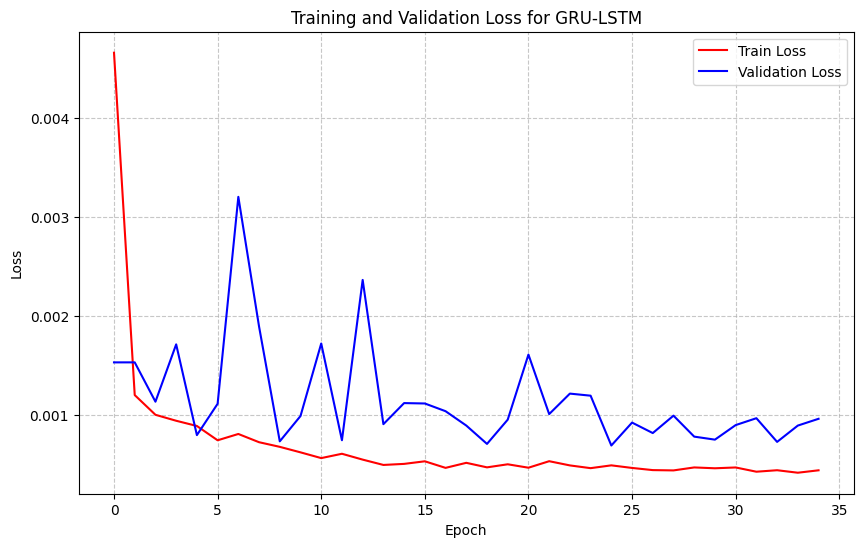

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training and Validation Loss for GRU-LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

# Predictions

In [ ]:
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values

# Need to create dummy array for inverse scaling as y is only 'Close'
y_pred_scaled = np.zeros((len(y_pred), len(feature_columns)))
y_pred_scaled[:, 0] = y_pred[:, 0]  #  places predicted values (which represent the Close price) into the first column (index 0) of this empty array, leaving the other columns as zeros.
y_pred = scaler.inverse_transform(y_pred_scaled)[:, 0]  # inverse transforms the scaled predictions to the original scale
y_test_scaled = np.zeros((len(y_test), len(feature_columns)))
y_test_scaled[:, 0] = y_test 
y_test = scaler.inverse_transform(y_test_scaled)[:, 0]  


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


# Evaluation Metrics

Performance Metrics
MAE: 8.88
RMSE: 11.96
R^2: 0.98
MAPE: 4.10%


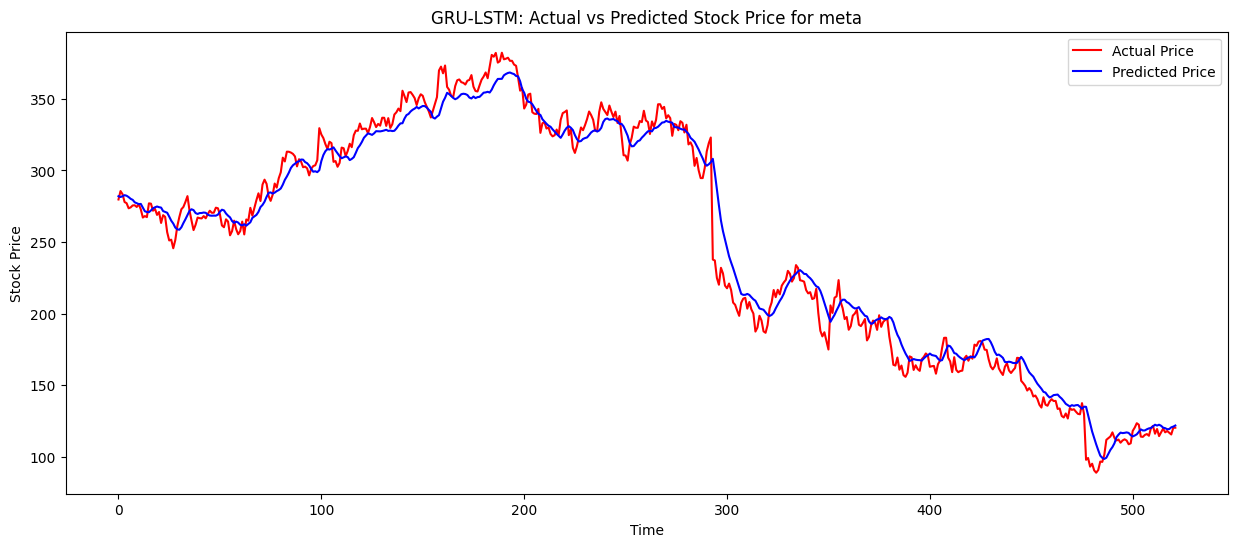

In [8]:
# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Performance Metrics")
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

# Plot 
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Price', color='red')
plt.plot(y_pred, label='Predicted Price', color='blue')
plt.title('GRU-LSTM: Actual vs Predicted Stock Price for meta')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



# Saving the model

In [9]:
# Save model
model.save('gru_lstm_model.keras')

# Save metrics to csv

In [10]:
def save_metrics(test_label, predicted, model_name, stock_name):
    """
    Calculate metrics and save to CSV.
    
    Parameters:
    - test_label: Actual values (y_test)
    - predicted: Predicted values (y_pred)
    - model_name: Name of the model (e.g., 'GRU-LSTM')
    - stock_name: Name of the stock (e.g., 'MSFT')
    """
    # Calculate metrics
    mse = mean_squared_error(test_label, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_label, predicted)
    mape = np.mean(np.abs((test_label - predicted) / test_label)) * 100
    r2 = r2_score(test_label, predicted)
    
    # Round to 4 decimal places
    mse = round(mse, 4)
    rmse = round(rmse, 4)
    mae = round(mae, 4)
    mape = round(mape, 4)
    r2 = round(r2, 4)
    
    # Create metrics dictionary
    metrics = {
        'Model': [model_name],
        'Stock': [stock_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'R2': [r2]
    }
    
    # Convert to DataFrame
    df_metrics = pd.DataFrame(metrics)
    
    # Save to CSV
    filename = f'metrics_{model_name}_{stock_name}.csv'
    df_metrics.to_csv(filename, index=False)
    
    # Print metrics
    print(f"\nMetrics for {model_name} on {stock_name}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"R² Score: {r2:.4f}")



In [11]:
# Save metrics to CSV
save_metrics(y_test, y_pred, model_name="GRU-LSTM", stock_name="META")


Metrics for GRU-LSTM on META:
Mean Squared Error (MSE): 142.9235
Root Mean Squared Error (RMSE): 11.9551
Mean Absolute Error (MAE): 8.8789
Mean Absolute Percentage Error (MAPE): 4.1026%
R² Score: 0.9794


# Visualization & Model Architecture

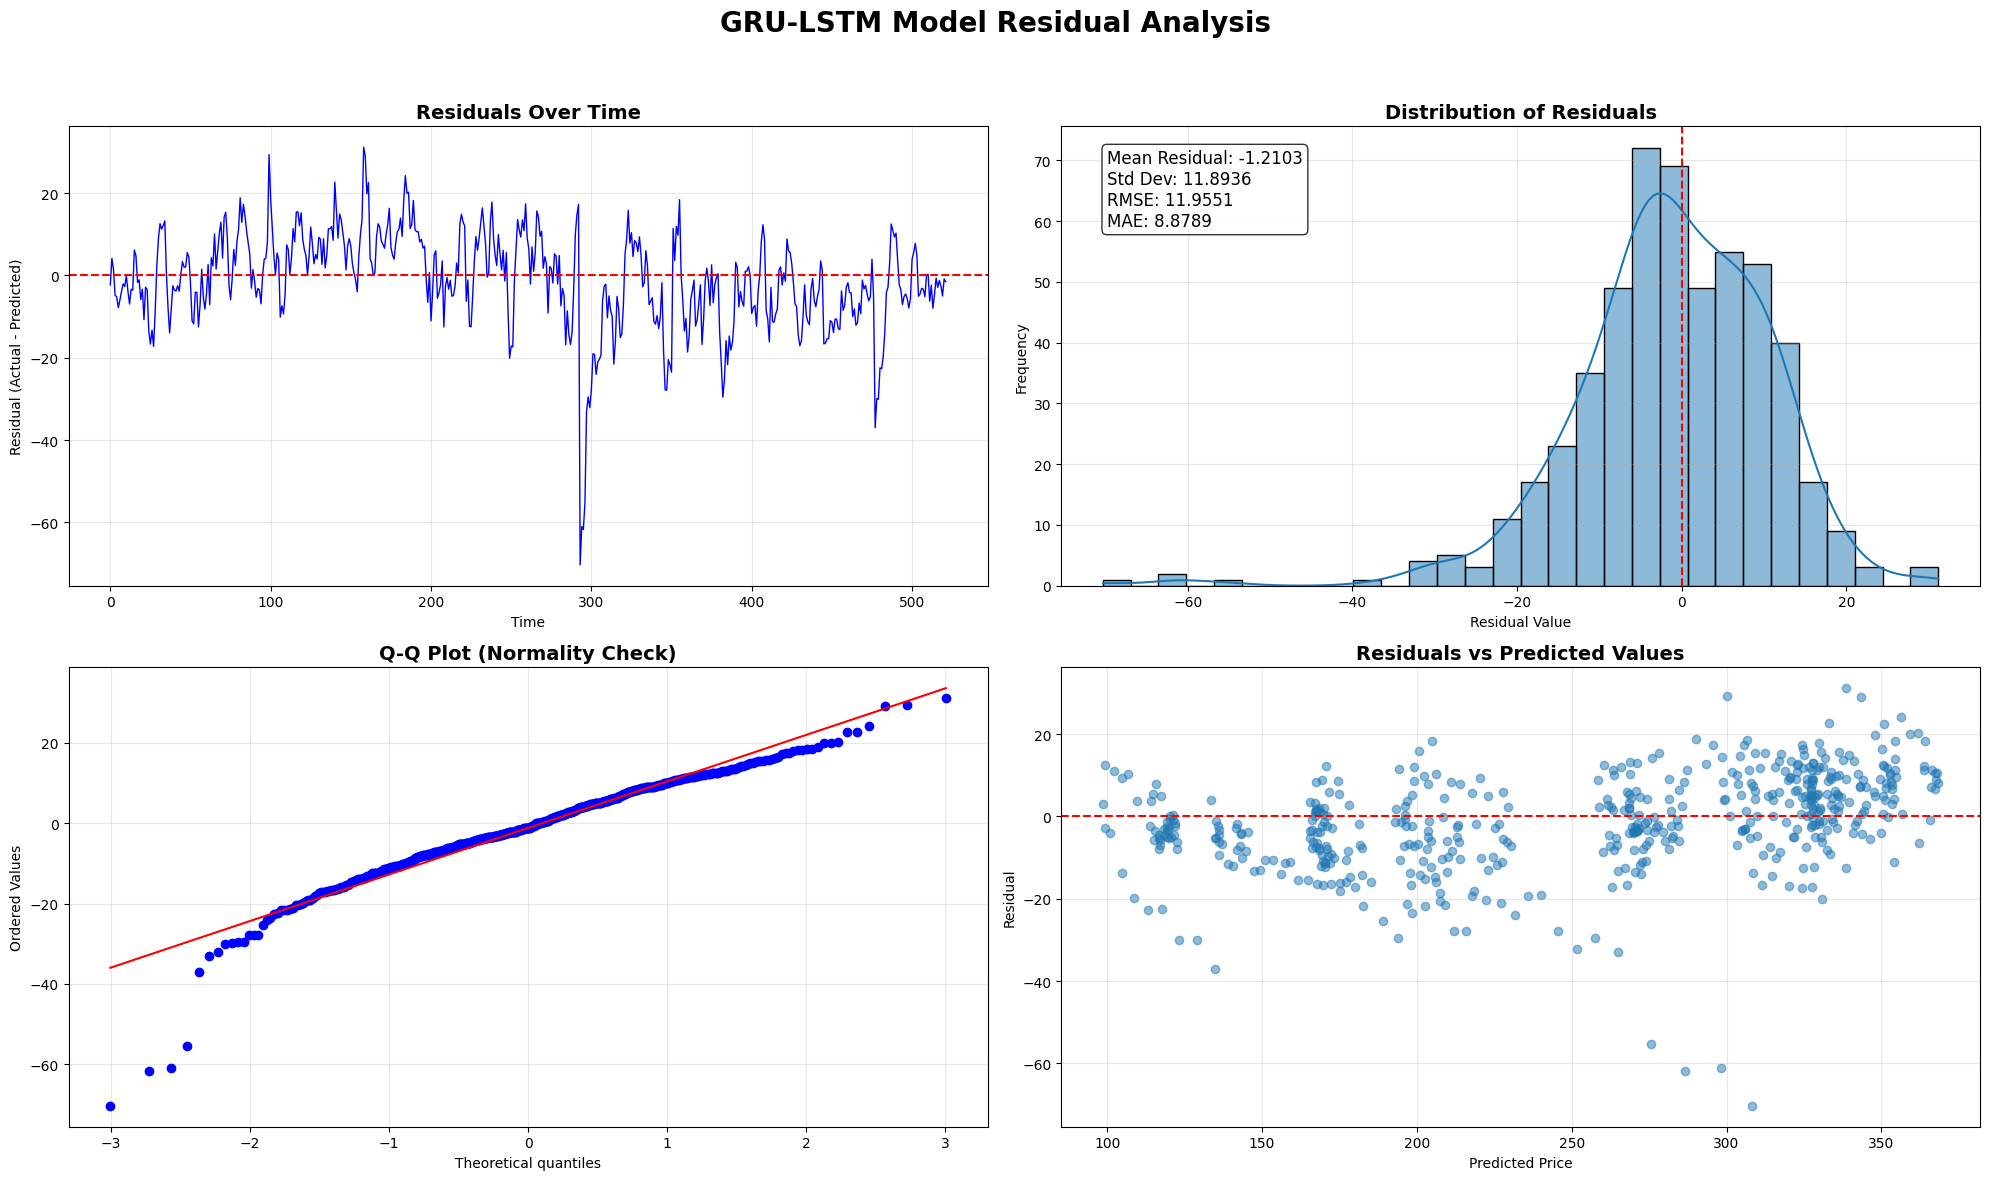

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

# Calculate residuals
residuals = y_test.flatten() - y_pred.flatten()

# Create figure
fig = plt.figure(figsize=(20, 12))
fig.suptitle('GRU-LSTM Model Residual Analysis', fontsize=20, fontweight='bold', y=0.98)

# 1. Residuals over time
plt.subplot(2, 2, 1)
plt.plot(residuals, 'b-', linewidth=1)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, alpha=0.3)

# 2. Histogram of residuals
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 3. Q-Q plot for normality assessment
plt.subplot(2, 2, 3)
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted values
plt.subplot(2, 2, 4)
plt.scatter(y_pred.flatten(), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Price')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

# Summary 
stats_text = (
    f"Mean Residual: {np.mean(residuals):.4f}\n"
    f"Std Dev: {np.std(residuals):.4f}\n"
    f"RMSE: {np.sqrt(np.mean(residuals**2)):.4f}\n"
    f"MAE: {np.mean(np.abs(residuals)):.4f}"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.subplot(2, 2, 2)
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=props)

# Use tight_layout with rect to leave room for the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('residual_analysis_gru-lstm.png', dpi=300)
plt.show()

In [13]:
# Plot the model architecture
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 15, 100)        │        32,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,605 (1.30 MB)

 Trainable params: 113,201 (442.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 226,404 (884.39 KB)

None
